In [1]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import glob
import pickle as pkl
import time
import os

import fbprophet

from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


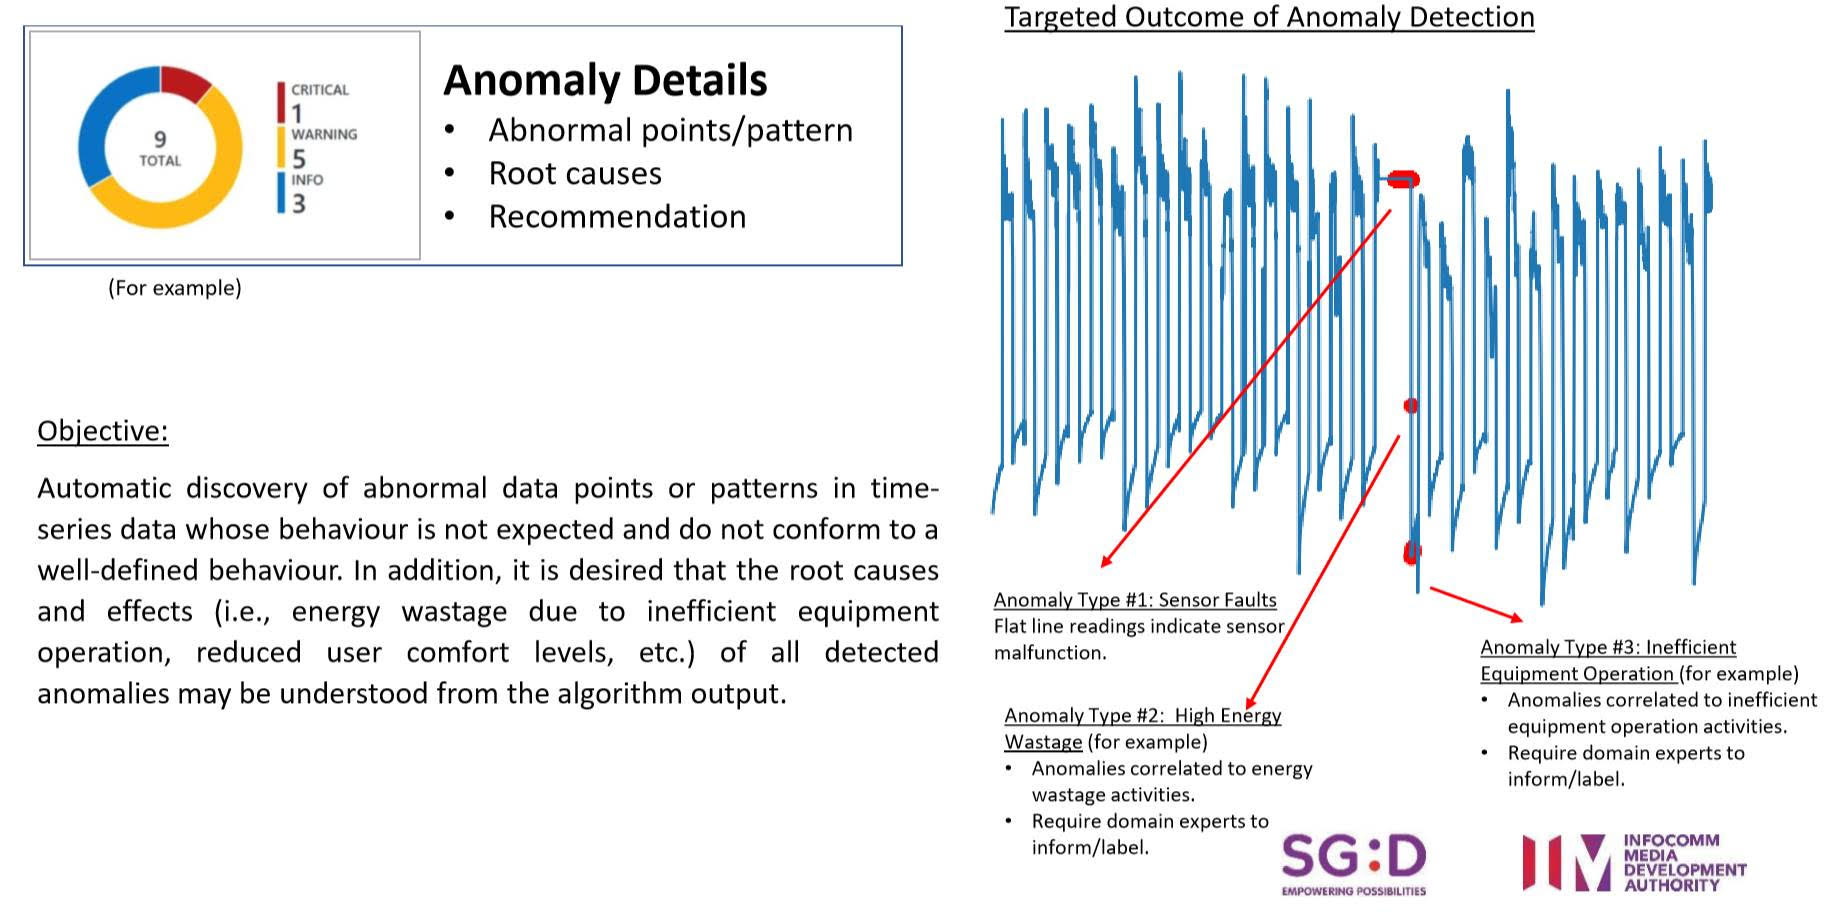

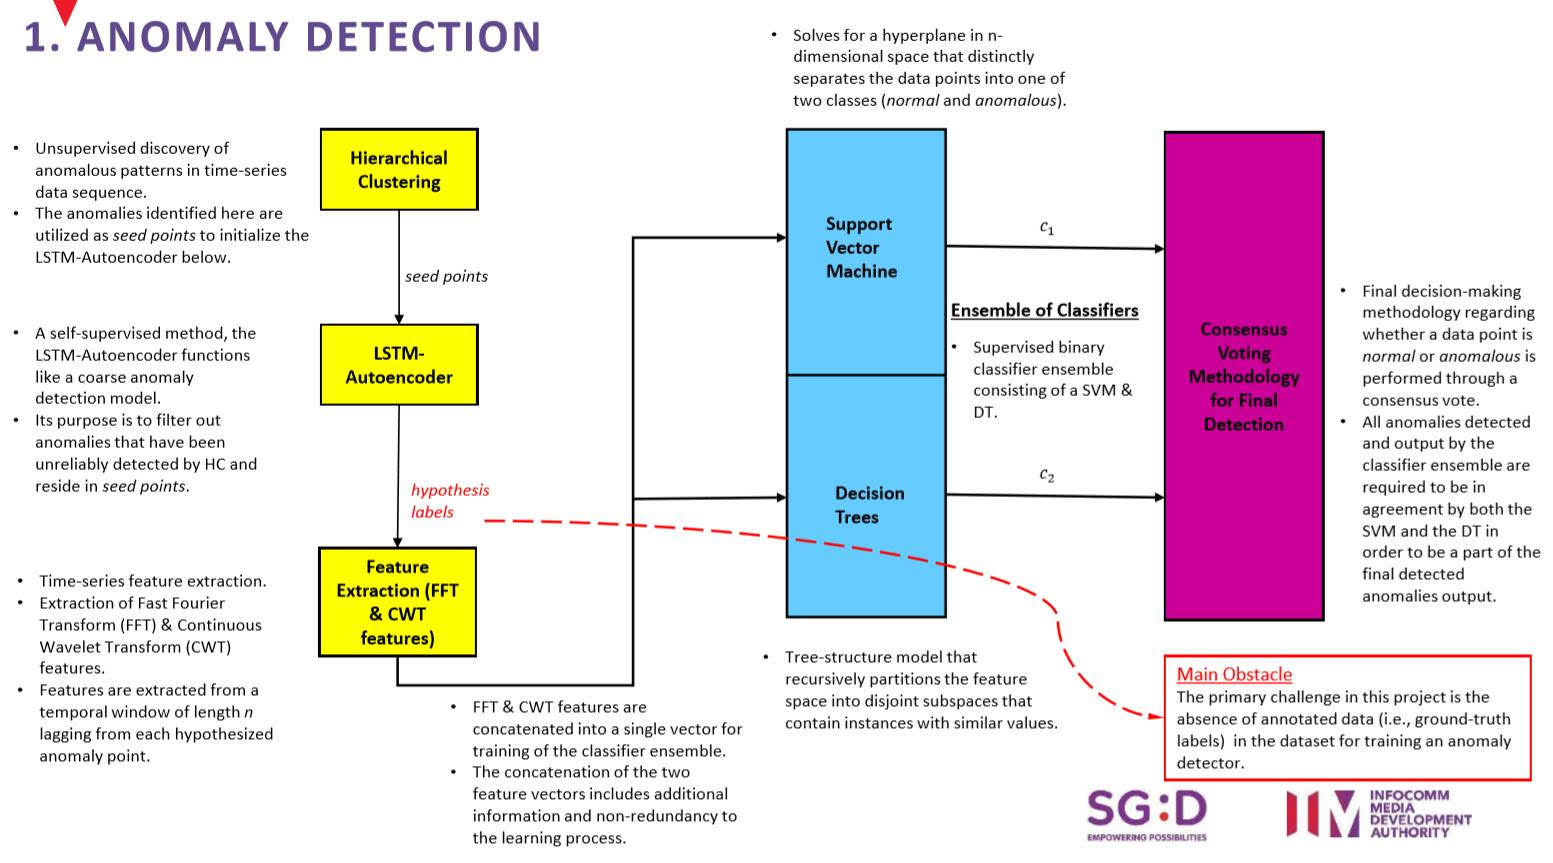

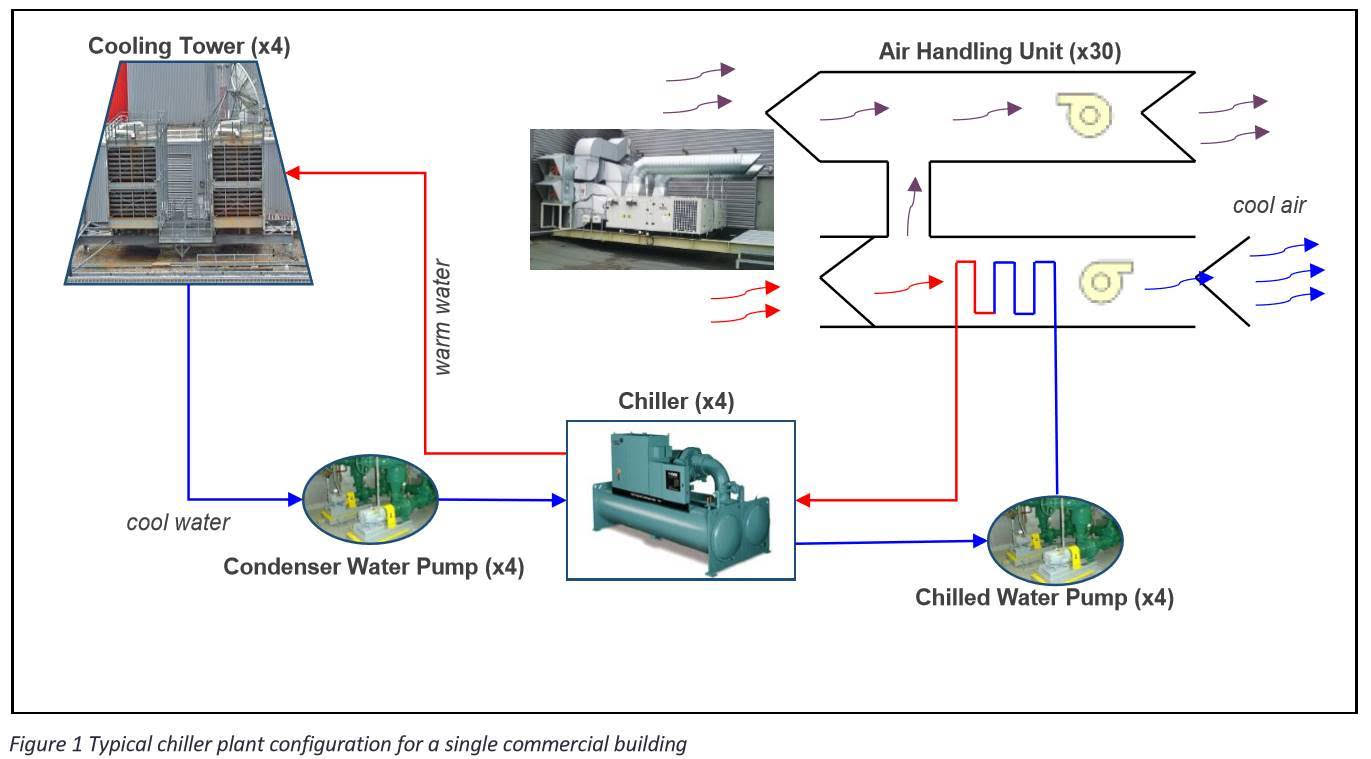
## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

## Read Data

In [2]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']
derivecol = ['(CWRT_syth)-(HLI Entering CHW Temp)']
timecols=['weekday', 'hourminute']

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

#### data_3

In [3]:
data_3 = pd.read_csv(rootPath+'data_3_prophet.csv', index_col='Unnamed: 0', date_parser=dateparse)

print(data_3.shape)
print(data_3.dtypes)
print(min(data_3.index), max(data_3.index))
display(data_3.head())


(17719, 28)
Date                                                        object
Time                                                        object
CWRT_syth                                                  float64
HLI Entering CHW Temp                                      float64
LABEL_(CWRT_syth)_(wrong_gap)                                 bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)                     bool
weekday                                                      int64
hourminute                                                   int64
Score_(CWRT_syth)_distanced                                float64
Score_(HLI Entering CHW Temp)_distanced                    float64
Score_(CWRT_syth)_cluster                                  float64
Score_(HLI Entering CHW Temp)_cluster                      float64
(CWRT_syth)-(HLI Entering CHW Temp)                        float64
CWRT_syth_pred                                             float64
CWRT_syth_pred_lower                              

,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),weekday,hourminute,Score_(CWRT_syth)_distanced,Score_(HLI Entering CHW Temp)_distanced,Score_(CWRT_syth)_cluster,Score_(HLI Entering CHW Temp)_cluster,(CWRT_syth)-(HLI Entering CHW Temp),CWRT_syth_pred,CWRT_syth_pred_lower,CWRT_syth_pred_upper,Score_(CWRT_syth)_fb,Score_(CWRT_syth)_fb_modified,HLI Entering CHW Temp_pred,HLI Entering CHW Temp_pred_lower,HLI Entering CHW Temp_pred_upper,Score_(HLI Entering CHW Temp)_fb,Score_(HLI Entering CHW Temp)_fb_modified,(CWRT_syth)-(HLI Entering CHW Temp)_pred,(CWRT_syth)-(HLI Entering CHW Temp)_pred_lower,(CWRT_syth)-(HLI Entering CHW Temp)_pred_upper,Score_((CWRT_syth)-(HLI Entering CHW Temp))_fb,Score_((CWRT_syth)-(HLI Entering CHW Temp))_fb_modified
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,7,0,0.0,NaN,27.467759,2.62796,NaN,31.078512,28.856809,33.153436,0.035330,0.035330,10.880021,9.323506,12.489211,NaN,NaN,20.476532,18.191196,23.137179,NaN,NaN
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,7,5,0.0,NaN,27.467759,2.62796,NaN,31.050151,28.839159,33.109129,0.171865,0.171865,10.910082,9.368597,12.447291,NaN,NaN,20.416064,18.078168,23.068238,NaN,NaN
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,7,10,0.0,0.0,27.467759,2.62796,20.529999,31.026189,28.868974,33.207650,0.319480,0.319480,10.944618,9.530245,12.746726,3.553419,3.553419,20.355538,17.841693,22.681612,0.536503,0.536503
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,7,15,0.0,NaN,27.467759,2.62796,NaN,31.006549,28.753629,33.327013,0.429174,0.429174,10.983519,9.636203,12.554081,NaN,NaN,20.294989,17.778333,22.897641,NaN,NaN
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,7,20,0.0,NaN,27.467759,2.62796,NaN,30.991137,28.613096,33.353044,0.550475,0.550475,11.026653,9.480103,12.719528,NaN,NaN,20.234456,17.915721,22.884016,NaN,NaN


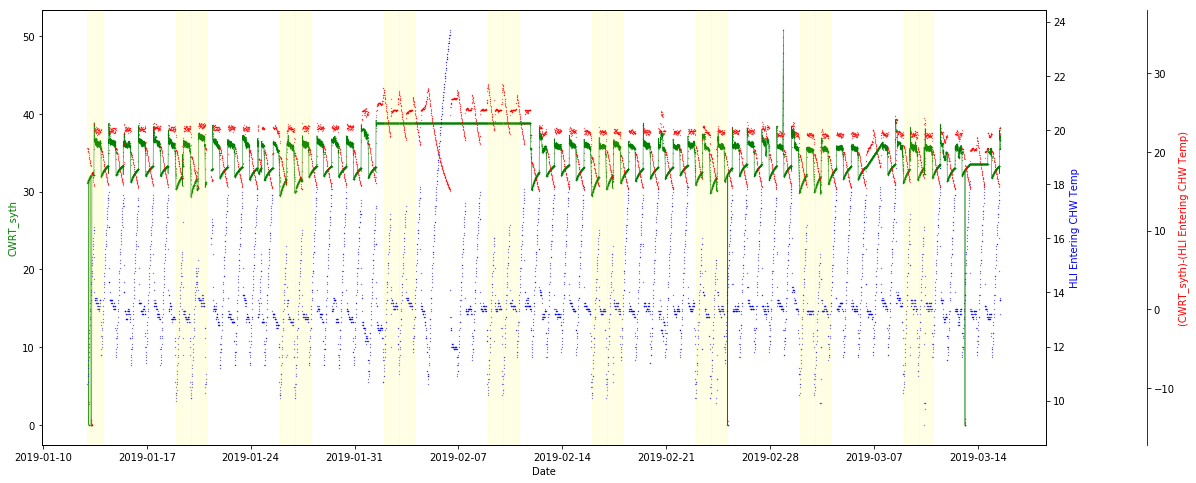

In [4]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))

for c, ax_, clr in zip(maincols+derivecol, [ax1, ax2, ax3], ['g', 'b', 'r']):
    ax_.plot_date(data_3.index, data_3[c], c=clr[0], 
                  markersize=0.5, marker='.', linewidth=0.5, linestyle='-')
    ax_.set_ylabel(c, color=clr)
    ax_.set_xlabel('Date')

tmp = data_3.index.to_frame()
tmp['wkday'] = data_3.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
plt.show()


In [14]:

pctoutlier_dict = {'CWRT_syth': 0.2, 
                   'HLI Entering CHW Temp': 0.02, 
                   '(CWRT_syth)-(HLI Entering CHW Temp)': 0.003}
thrshold_dict = {k: np.nanpercentile(data_3['Score_('+k+')_fb_modified'].values, 
                                     (1-pctoutlier_dict[k])*100) 
                 for k in maincols+derivecol}
print(thrshold_dict)


{'CWRT_syth': 5.969449213009812, 'HLI Entering CHW Temp': nan, '(CWRT_syth)-(HLI Entering CHW Temp)': nan}


/Users/phuw273g/.conda/envs/untitled/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


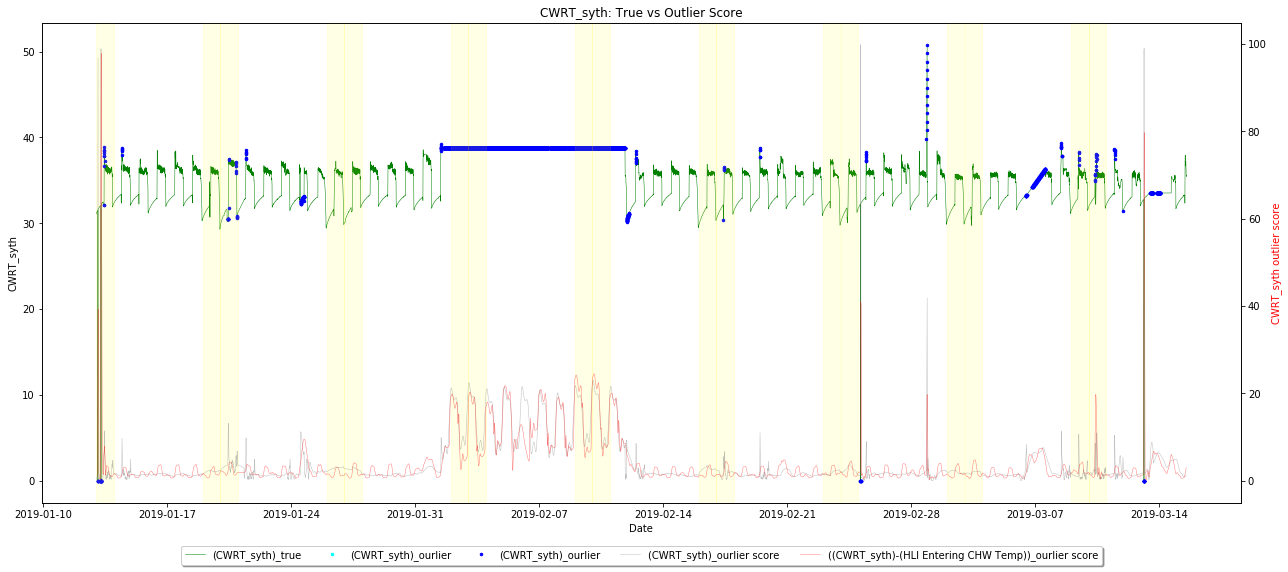

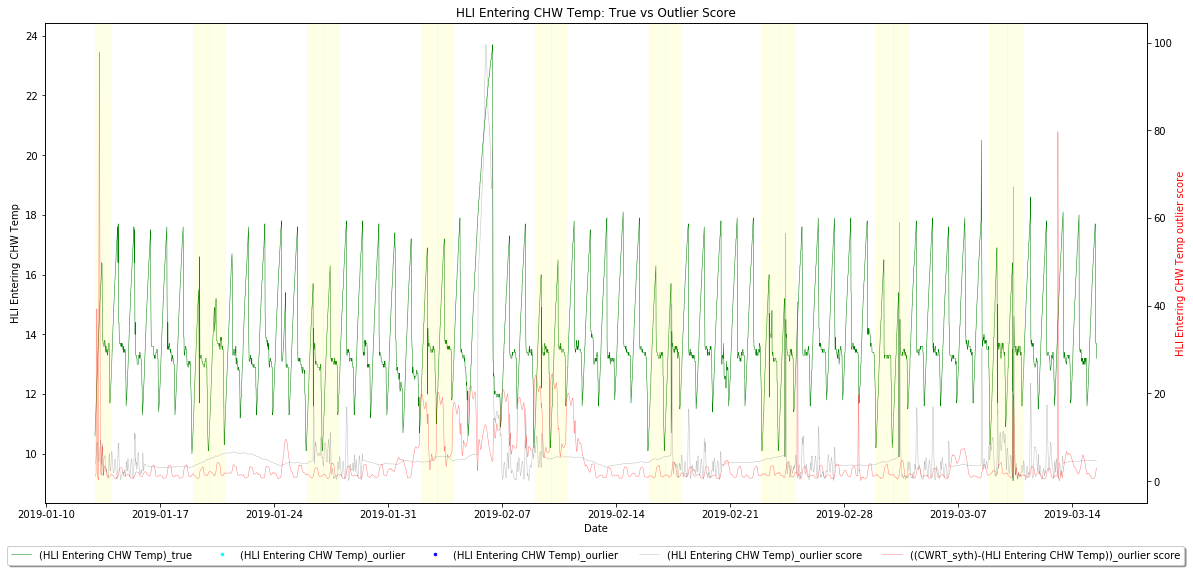

In [11]:
for col in maincols:
    thres_main = thrshold_dict[col]
    thres_derive = thrshold_dict[derivecol[0]]
    truedata = data_3.dropna(subset=[col]).copy()
    
    # plot: compare true with score
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1))

    L1 = ax1.plot_date(truedata.index, truedata[col], 
                  c='green',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_true')
    sub_derive = truedata.loc[truedata['Score_('+derivecol[0]+')_fb_modified']>thres_derive, col].dropna()
    L2 = ax1.plot_date(sub_derive.index, sub_derive, 
                  c='cyan',  markersize=5,  marker='.', linewidth=0.5, linestyle='', label='('+col+')_ourlier') 
    sub_main = truedata.loc[truedata['Score_('+col+')_fb_modified']>thres_main, col].dropna()
    L3 = ax1.plot_date(sub_main.index, sub_main, 
                  c='blue',  markersize=5,  marker='.', linewidth=0.5, linestyle='', label='('+col+')_ourlier')
   
    ax1.set_ylabel(col, color='black')
    ax1.set_xlabel('Date')

    tmp = data_3.index.to_frame()
    tmp['wkday'] = data_3.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    i = 0
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        if i == len(allwknddate)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
        i += 1

    tmp1 = truedata.dropna(subset=['Score_('+col+')_fb_modified'])
    L4 = ax2.plot_date(tmp1.index, tmp1['Score_('+col+')_fb_modified'], 
                  c='grey',  markersize=0.5,  marker='', 
                  linewidth=0.5, linestyle='-', label='('+col+')_ourlier score', alpha=0.5)
    tmp2 = truedata.dropna(subset=['Score_('+derivecol[0]+')_fb_modified'])
    L5 = ax2.plot_date(tmp2.index, tmp2['Score_('+derivecol[0]+')_fb_modified'], 
                  c='red',  markersize=0.5,  marker='', 
                  linewidth=0.5, linestyle='-', label='('+derivecol[0]+')_ourlier score', alpha=0.5)    
    
    ax2.set_ylabel(col+' outlier score', color='red')
    ax2.set_xlabel('Date')

    plt.title(col+': True vs Outlier Score')
    lns = L1+L2+L3+L4+L5
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    #ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    plt.tight_layout()
    plt.show()

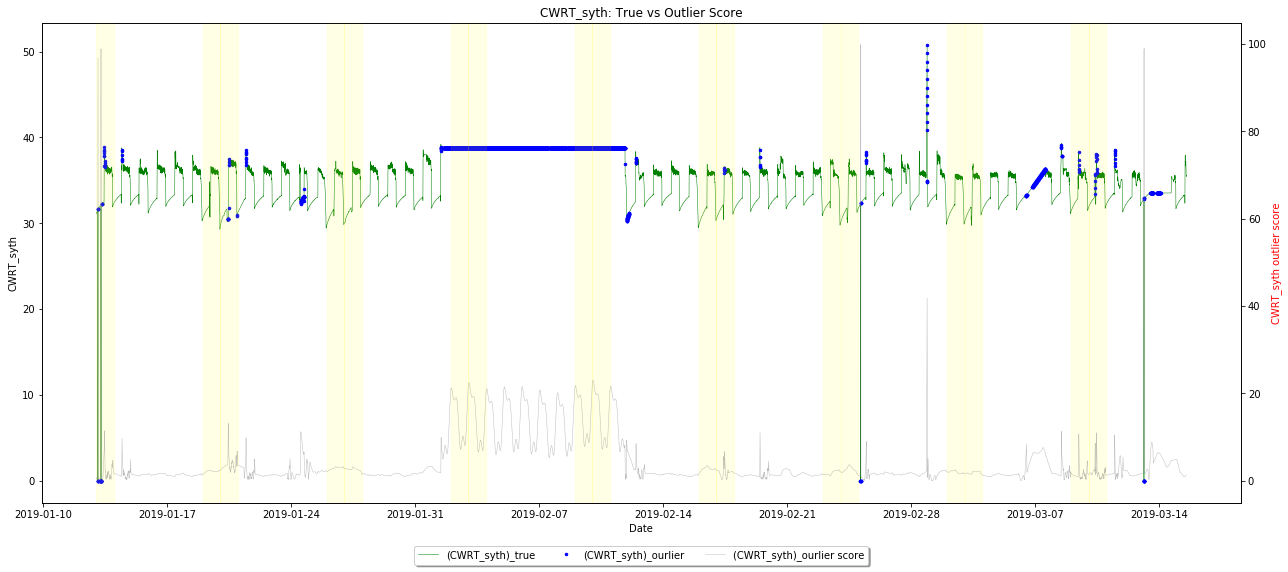

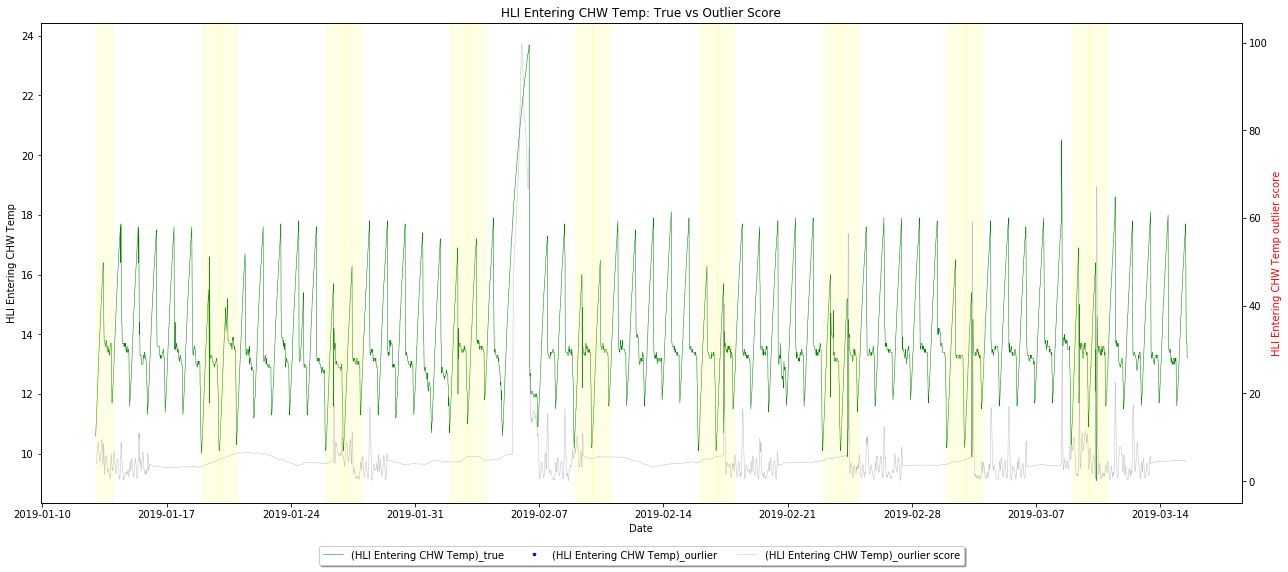

In [15]:
for col in maincols:
    thres_main = thrshold_dict[col]
    thres_derive = thrshold_dict[derivecol[0]]
    truedata = data_3.dropna(subset=[col]).copy()
    
    # plot: compare true with score
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1))

    L1 = ax1.plot_date(truedata.index, truedata[col], 
                  c='green',  markersize=0.5,  marker='', linewidth=0.5, linestyle='-', label='('+col+')_true')
#    sub_derive = truedata.loc[truedata['Score_('+derivecol[0]+')_fb_modified']>thres_derive, col].dropna()
#     L2 = ax1.plot_date(sub_derive.index, sub_derive, 
#                   c='cyan',  markersize=5,  marker='.', linewidth=0.5, linestyle='', label='('+col+')_ourlier') 
    sub_main = truedata.loc[truedata['Score_('+col+')_fb_modified']>thres_main, col].dropna()
    L3 = ax1.plot_date(sub_main.index, sub_main, 
                  c='blue',  markersize=5,  marker='.', linewidth=0.5, linestyle='', label='('+col+')_ourlier')
   
    ax1.set_ylabel(col, color='black')
    ax1.set_xlabel('Date')

    tmp = data_3.index.to_frame()
    tmp['wkday'] = data_3.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    i = 0
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        if i == len(allwknddate)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
        i += 1

    tmp1 = truedata.dropna(subset=['Score_('+col+')_fb_modified'])
    L4 = ax2.plot_date(tmp1.index, tmp1['Score_('+col+')_fb_modified'], 
                  c='grey',  markersize=0.5,  marker='', 
                  linewidth=0.5, linestyle='-', label='('+col+')_ourlier score', alpha=0.5)
#     tmp2 = truedata.dropna(subset=['Score_('+derivecol[0]+')_fb_modified'])
#     L5 = ax2.plot_date(tmp2.index, tmp2['Score_('+derivecol[0]+')_fb_modified'], 
#                   c='red',  markersize=0.5,  marker='', 
#                   linewidth=0.5, linestyle='-', label='('+derivecol[0]+')_ourlier score', alpha=0.5)    
    
    ax2.set_ylabel(col+' outlier score', color='red')
    ax2.set_xlabel('Date')

    plt.title(col+': True vs Outlier Score')
    lns = L1+L3+L4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    #ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    plt.tight_layout()
    plt.show()

## Get final scores

In [48]:
keepcols = ['Date', 'Time', 'CWRT_syth', 'HLI Entering CHW Temp',
            'LABEL_(CWRT_syth)_(wrong_gap)', 'LABEL_(HLI Entering CHW Temp)_(wrong_gap)', 
            'Score_(CWRT_syth)_fb_modified', 'Score_(HLI Entering CHW Temp)_fb_modified']
data_final = data_3[keepcols].copy().rename(columns={
    'Score_('+k+')_fb_modified': 'Score_('+k+')_outlier' for k in maincols})

for col in maincols:
    data_final['LABEL_('+col+')_(outlier)'] = False
    data_final.loc[data_final['Score_('+col+')_outlier']>thrshold_dict[col], 'LABEL_('+col+')_(outlier)'] = True

print(data_final.shape)
print(data_final.dtypes)
print(min(data_final.index), max(data_final.index))
display(data_final.head())
display(data_final.describe())

(17719, 10)
Date                                          object
Time                                          object
CWRT_syth                                    float64
HLI Entering CHW Temp                        float64
LABEL_(CWRT_syth)_(wrong_gap)                   bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)       bool
Score_(CWRT_syth)_outlier                    float64
Score_(HLI Entering CHW Temp)_outlier        float64
LABEL_(CWRT_syth)_(outlier)                     bool
LABEL_(HLI Entering CHW Temp)_(outlier)         bool
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


,Date,Time,CWRT_syth,HLI Entering CHW Temp,LABEL_(CWRT_syth)_(wrong_gap),LABEL_(HLI Entering CHW Temp)_(wrong_gap),Score_(CWRT_syth)_outlier,Score_(HLI Entering CHW Temp)_outlier,LABEL_(CWRT_syth)_(outlier),LABEL_(HLI Entering CHW Temp)_(outlier)
2019-01-13 00:00:00,2019-01-13,0000h,31.090000,NaN,False,False,0.035330,NaN,False,False
2019-01-13 00:05:00,2019-01-13,0005h,31.106000,NaN,False,False,0.171865,NaN,False,False
2019-01-13 00:10:00,2019-01-13,0010h,31.129999,10.6,False,False,0.319480,3.553419,False,False
2019-01-13 00:15:00,2019-01-13,0015h,31.146000,NaN,False,False,0.429174,NaN,False,False
2019-01-13 00:20:00,2019-01-13,0020h,31.170000,NaN,False,False,0.550475,NaN,False,False


,CWRT_syth,HLI Entering CHW Temp,Score_(CWRT_syth)_outlier,Score_(HLI Entering CHW Temp)_outlier
count,17615.000000,5868.000000,17615.000000,5868.000000
mean,34.761378,13.929772,4.240915,5.680866
std,3.042954,1.861147,6.900248,9.683205
min,0.000000,9.100000,0.001350,0.000000
25%,32.669998,13.000000,1.307951,3.398413
50%,35.330001,13.500000,1.725515,4.235358
75%,36.368999,14.800000,3.528576,5.298695
max,50.804002,23.700001,100.000000,100.000000


In [49]:
data_final.to_csv('data_final.csv', index=True)